# Assignment 1: Primitive Sensitivity Analysis
#### Moritz Kick, Rami El Immam, Maximilian Nowak

## Implementation of the model
### 1. Implement SEIR model

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display

beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

# Define initial conditions
N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
y0 = [S0, E0, I0, R0]

# Define the system of differential equations
def seir_model(y, t, beta, alpha, gamma, N):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]


# Define time points (60 Weeks)
t = np.linspace(0, 60, 60)


### 2. & 3. Plot and play with the parameters

In [61]:
# Define sliders for parameters
beta_slider = widgets.FloatSlider(
    value=beta, min=0.0, max=5.0, step=0.01, description='beta:')
alpha_slider = widgets.FloatSlider(
    value=alpha, min=0.0, max=5.0, step=0.01, description='alpha:')
gamma_slider = widgets.FloatSlider(
    value=gamma, min=0.0, max=5.0, step=0.01, description='gamma:')
i0_slider = widgets.IntSlider(
    value=i0, min=0, max=N, step=1e3, description='i0:')

# Define a function to update the plot
def update_plot(beta, alpha, gamma, i0):
    x0 = (beta, alpha, gamma, N)
    y0 = S0, E0, i0, R0
    sol = odeint(seir_model, y0, t, args=x0)
    S, E, I, R = sol.T
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, E, 'r', label='Exposed')
    plt.plot(t, I, 'g', label='Infected')
    plt.plot(t, R, 'm', label='Recovered')
    plt.title('SEIR Model')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Population')
    plt.legend()
    plt.show()


# Display the plot and sliders
interactive_plot = widgets.interactive(
    update_plot, beta=beta_slider, alpha=alpha_slider, gamma=gamma_slider, i0=i0_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)


interactive(children=(FloatSlider(value=1.5555555555555556, description='beta:', max=5.0, step=0.01), FloatSli…

## Perturbation of a nominal value
### 4. Define Hk in mathematical terms

$$
H_k := [\beta - (\beta \cdot p_k), \beta + (\beta \cdot p_k)]^T \times [\alpha - (\alpha \cdot p_k), \alpha + (\alpha \cdot p_k)]^T \times [\gamma - (\gamma \cdot p_k), \gamma + (\gamma \cdot p_k)]^T \times [I_0 - (I_0 \cdot p_k), I_0 + (I_0 \cdot p_k)]^T
$$

$$
= \beta \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix} \times
\alpha \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix} \times
\gamma \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix} \times
N_0 \begin{bmatrix}1 - p_k\cr 1 + p_k\end{bmatrix},
$$

<center> mit </center>

$$
\beta, \alpha, \gamma, N_0 \in \R,
$$

$$
k \in \N,
$$

$$
p_k := \{x \in \R : 0 \le x \le 1 \}
$$


### 5./6./7. Include C(t), C0 = C(0) and plot the curve

In [62]:
 # include curve for cumulative cases C(t)

# include C0
C0 = I0
y0 = [S0, E0, I0, R0, C0]

# Define the system of differential equations
def seir_model_update(y, t, beta, alpha, gamma, N):
    S, E, I, R, C = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    DCdt = alpha * E
    return [dSdt, dEdt, dIdt, dRdt, DCdt]

In [63]:
def update_plot(beta, alpha, gamma, i0):
    x0 = (beta, alpha, gamma, N)
    y0 = S0, E0, i0, R0, C0
    sol = odeint(seir_model_update, y0, t, args=x0)
    S, E, I, R, C = sol.T
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, E, 'r', label='Exposed')
    plt.plot(t, I, 'g', label='Infected')
    plt.plot(t, R, 'm', label='Recovered')
    plt.plot(t, C, 'c', label='Cumulative cases')
    plt.title('SEIRC Model')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

interactive_plot = widgets.interactive(
    update_plot, beta=beta_slider, alpha=alpha_slider, gamma=gamma_slider, i0=i0_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)


interactive(children=(FloatSlider(value=1.5555555555555556, description='beta:', max=5.0, step=0.01), FloatSli…

### 8. Sample data (perturbations=[5 %, 10 %], N=10^3)

In [64]:
rng = np.random.default_rng()

def get_hyperc(x0, pert):
    """Sampels a given data vector x0 by a certain perturbation

    Args:
        x0 (np.array): data vector to perturb
        pert (float): percentage value of perturbation

    Returns:
        tuple: tuple of perturbed parameters
    """
    h = [0,0,0,0]
    for i in range(len(h)):
        h[i] = rng.uniform(x0[i]*(1-pert), x0[i]*(1+pert))
    return (h[0], h[1], h[2], h[3])

def run_simulations(seir_model, p, N):
    """Generates data for solutions of the SEIR ode with a
    certain amount perturbation. 

    Args:
        seir_model (function): function defining a system of ode
        p (float): percentage of perturbation
        N (int): number of simulations
    """
    with open("C_data_" + str(int(p*100)), "wb") as fh1:
        with open("I_data_" + str(int(p*100)), "wb") as fh2:
            for _ in range(N):
                results = odeint(seir_model, y0, t, args=get_hyperc(x0, p))
                C_data = results[:, 4]
                np.savetxt(fh1, np.column_stack(C_data))
                I_data = results[:, 2]
                np.savetxt(fh2, np.column_stack(I_data))

# model parameters
N = 80e6
beta = 14/9
alpha = 7/3
gamma = 7/9

# inital conditions
I0 = 1000
S0 = N-I0
E0 = 0
R0 = 0
C0 = I0

# simulation time
T = 60
t = np.linspace(0, T, T+1)

x0 = (beta, alpha, gamma, N)
y0 = S0, E0, I0, R0, C0

run_simulations(seir_model_update, 0.05, N=1000)
run_simulations(seir_model_update, 0.10, N=1000)

### 9. Plot empirical distribution of C(t, x)

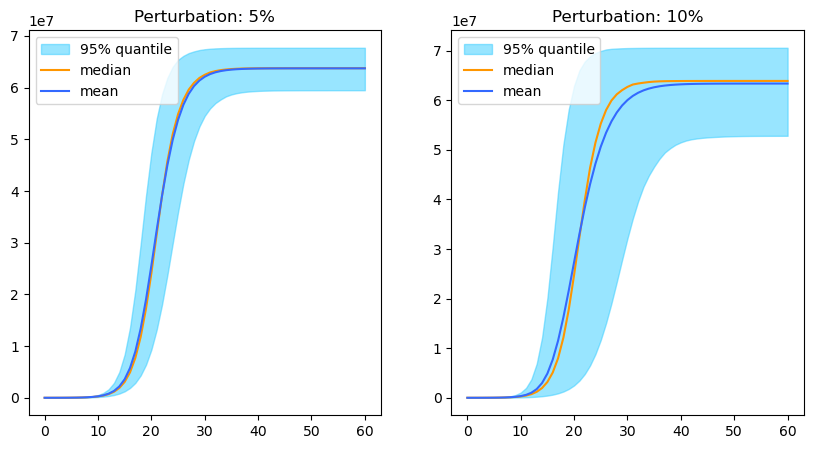

In [65]:
def get_metrics(C_data):
    """Returns metrics to a given dataset

    Args:
        C_data (np.array): the dataset

    Returns:
        tuple: mean, median, quantile_high, quantile_low
    """
    n = C_data.shape[1]
    mean = C_data.mean(0)
    median = np.zeros(n)
    quant_high = np.zeros(n)
    quant_low = np.zeros(n)
    for t in range(n):
        median[t] = np.median(C_data[:, t])
        quant_high[t] = np.quantile(C_data[:, t], 0.975)
        quant_low[t] = np.quantile(C_data[:, t], 0.025)
    return mean, median, quant_high, quant_low

# load data and retrieve metrics
C_data5 = np.loadtxt("C_data_5")
metrics5 = get_metrics(C_data5)

C_data10 = np.loadtxt("C_data_10")
metrics10 = get_metrics(C_data10)

# plot data for C and I 
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].fill_between(t, metrics5[2], metrics5[3], color="#33ccff", alpha=0.5, label='95% quantile')
ax[0].plot(t, metrics5[1], label='median', color='#ff9600')
ax[0].plot(t, metrics5[0], label='mean', color='#3369ff')
ax[0].set_title("Perturbation: 5%")
ax[0].legend()
ax[1].fill_between(t, metrics10[2], metrics10[3], color="#33ccff", alpha=0.5, label='95% quantile')
ax[1].plot(t, metrics10[1], label='median', color='#ff9600')
ax[1].plot(t, metrics10[0], label='mean', color='#3369ff')
ax[1].set_title("Perturbation: 10%")
ax[1].legend()
plt.show()

### 10. Empirical distribution of G1 and G2(X)

In [66]:
# O1(G1(x)): final number of cumulative cases
def G1(data): return data[:, -1]

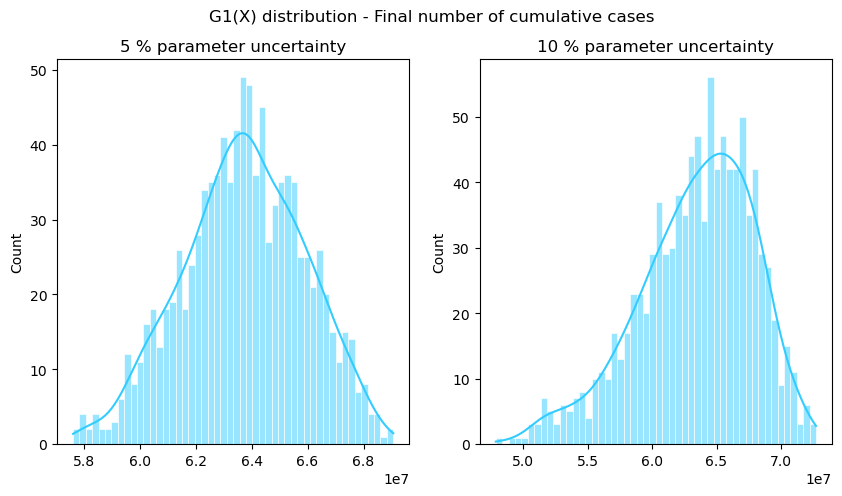

In [67]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('G1(X) distribution - Final number of cumulative cases\n')

ax[0].set_title('5 % parameter uncertainty')
sns.histplot(ax=ax[0], data=G1(C_data5), color="#33ccff", edgecolor = "white", kde=True, bins=50)

ax[1].set_title('10 % parameter uncertainty')
sns.histplot(ax=ax[1], data=G1(C_data10), color="#33ccff", edgecolor = "white", kde=True, bins=50)

plt.show()

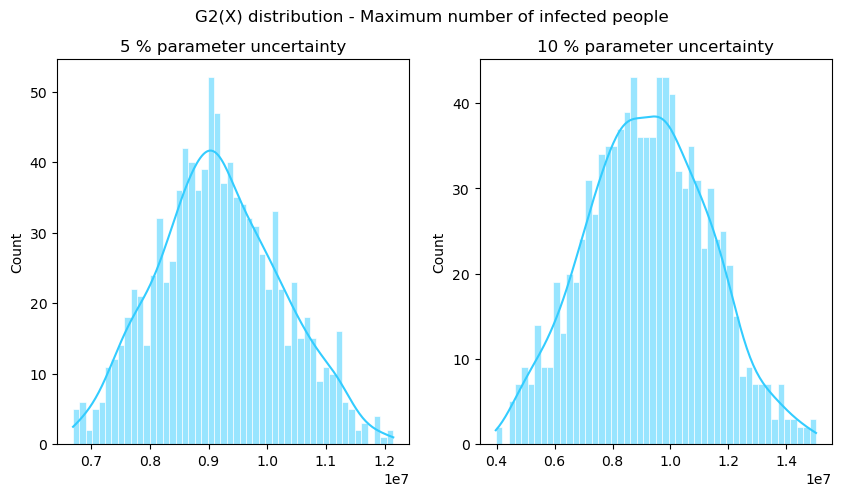

In [68]:
# O2(G2(x)): peak of infection curve
def G2(data): return np.amax(data, axis=1)

I_data5 = np.loadtxt("I_data_5")
I_data10 = np.loadtxt("I_data_10")

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('G2(X) distribution - Maximum number of infected people')

ax[0].set_title('5 % parameter uncertainty')
sns.histplot(ax=ax[0], data=G2(I_data5), color="#33ccff", edgecolor = "white", kde=True, bins=50)

ax[1].set_title('10 % parameter uncertainty')
sns.histplot(ax=ax[1], data=G2(I_data10), color="#33ccff", edgecolor = "white", kde=True, bins=50)

plt.show()


### 11. Empirical quantile intervals of $G_1(X)$ and $G_2(X)$

In [69]:
for s, op, data5, data10 in [("G1(X)", G1, C_data5, C_data10), ("G2(X)", G2, I_data5, I_data10)]:
    high_quant5 = np.quantile(op(data5), 0.975)
    low_quant5 = np.quantile(op(data5), 0.025)

    high_quant10 = np.quantile(op(data10), 0.975)
    low_quant10 = np.quantile(op(data10), 0.025)
    
    print(s + " 5%%: [%f, %f]" % (low_quant5, high_quant5))
    print(s+ " 10%%: [%f, %f]" % (low_quant10, high_quant10))

G1(X) 5%: [59486082.028338, 67697596.414710]
G1(X) 10%: [52843730.393371, 70599324.541151]
G2(X) 5%: [7255453.844969, 11260215.839263]
G2(X) 10%: [5128380.773368, 13387414.013417]


### 12. Pearson Correlation

#### Coefficient matrix of G1(X) and G2(x) with 5 % perturbation

In [70]:
np.corrcoef(G1(C_data5), G2(I_data5))


array([[1.        , 0.99286173],
       [0.99286173, 1.        ]])

#### Coefficient matrix of G1(X) and G2(X) with 10 % perturbation

In [71]:
np.corrcoef(G1(C_data10), G2(I_data10))

array([[1.       , 0.9815353],
       [0.9815353, 1.       ]])